<a href="https://colab.research.google.com/github/christian-creator/brain_cancer_segmentation/blob/master/segmentation_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!tar -xvf "/content/drive/MyDrive/brain_seg/kaggle.tar.gz" -C "/content"

In [ ]:
import os
import sys
import cv2 as cv
import seaborn as sns
import random
random.seed(0)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,sys
import random
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader
import math
import cv2 as cv
import sys

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

# Encoding the dataset

**Creating a datframe to store paths of the X and y**

In [ ]:
def classify_cancer_using_mask(image_path):
    if np.sum(cv.imread(image_path)) == 0:
        return 0
    else:
        return 1

def generate_path_dataframe(path_to_folders):
    image_paths = dict()
    counter = 0
    for folder in os.listdir(path_to_folders):
        path_to_folder = os.path.join(path_to_folders,folder)
        if os.path.isdir(path_to_folder):
            for file in os.listdir(path_to_folder):
                counter += 1
                path_to_file = os.path.join(path_to_folder,file)
                patient_slice = file.replace(".tif","").replace("_mask","") #If on collab
                mask = True if "mask" in file else False
                if patient_slice not in image_paths.keys():
                    if mask:
                        image_paths[patient_slice] = {"mask":path_to_file}
                    else:
                        image_paths[patient_slice] = {"image":path_to_file}
                else:
                    if mask:
                        image_paths[patient_slice]["mask"]  = path_to_file
                    else:
                        image_paths[patient_slice]["image"] = path_to_file

    image_df = pd.DataFrame.from_dict(image_paths).T
    image_df.reset_index(inplace=True)
    image_df = image_df.rename(columns={'index': 'patient_slice'})
    image_df["patient"] = ["_".join(x.split("_")[:4]) for x in image_df["patient_slice"]]
    image_df["diagnosis"] = image_df["mask"].apply(classify_cancer_using_mask)
    image_df["slice"] = [int(x.split("_")[-1]) for x in image_df["patient_slice"]]
    return image_df


In [ ]:
path_to_folder = "/content/kaggle_3m"
image_df = generate_path_dataframe(path_to_folder)
image_df = image_df[(image_df.slice <= 58) & ((image_df.slice >= 5))]
image_df = image_df.sample(frac=1, random_state=1).reset_index(drop=True)
image_df = image_df[~image_df['patient_slice'].str.contains("\._")]
image_df

,patient_slice,mask,image,patient,diagnosis,slice
2,TCGA_CS_6668_20011025_14,/content/kaggle_3m/TCGA_CS_6668_20011025/TCGA_...,/content/kaggle_3m/TCGA_CS_6668_20011025/TCGA_...,TCGA_CS_6668_20011025,0,14
4,TCGA_DU_8164_19970111_26,/content/kaggle_3m/TCGA_DU_8164_19970111/TCGA_...,/content/kaggle_3m/TCGA_DU_8164_19970111/TCGA_...,TCGA_DU_8164_19970111,1,26
5,TCGA_DU_8162_19961029_10,/content/kaggle_3m/TCGA_DU_8162_19961029/TCGA_...,/content/kaggle_3m/TCGA_DU_8162_19961029/TCGA_...,TCGA_DU_8162_19961029,0,10
6,TCGA_DU_8167_19970402_13,/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_...,/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_...,TCGA_DU_8167_19970402,1,13
7,TCGA_HT_7605_19950916_15,/content/kaggle_3m/TCGA_HT_7605_19950916/TCGA_...,/content/kaggle_3m/TCGA_HT_7605_19950916/TCGA_...,TCGA_HT_7605_19950916,0,15
...,...,...,...,...,...,...
6737,TCGA_FG_5962_20000626_41,/content/kaggle_3m/TCGA_FG_5962_20000626/TCGA_...,/content/kaggle_3m/TCGA_FG_5962_20000626/TCGA_...,TCGA_FG_5962_20000626,1,41
6738,TCGA_DU_6405_19851005_31,/content/kaggle_3m/TCGA_DU_6405_19851005/TCGA_...,/content/kaggle_3m/TCGA_DU_6405_19851005/TCGA_...,TCGA_DU_6405_19851005,0,31
6739,TCGA_FG_6690_20020226_8,/content/kaggle_3m/TCGA_FG_6690_20020226/TCGA_...,/content/kaggle_3m/TCGA_FG_6690_20020226/TCGA_...,TCGA_FG_6690_20020226,0,8
6740,TCGA_DU_5871_19941206_27,/content/kaggle_3m/TCGA_DU_5871_19941206/TCGA_...,/content/kaggle_3m/TCGA_DU_5871_19941206/TCGA_...,TCGA_DU_5871_19941206,1,27


**In Collab there is a wierd relationship with paths**

In [ ]:
class BrainMriDataset(Dataset):
    def __init__(self, df, transforms,train_transforms=None,augmented_path=None,number_generated=None):
        self.df = df
        self.transforms = transforms
        if train_transforms:
            self.train_transforms = train_transforms
            self.augmented_path = augmented_path
            self.number_generated = number_generated
            self.generate_augmented_data()

    def generate_augmented_data(self):
        # Create augmented directory
        os.system(f"mkdir -p {self.augmented_path}")
        # Save all images to augmented directory
        # Generate additional images
        augment_sample = random.sample(range(len(self.df)),self.number_generated)
        for sample in augment_sample:
            sample_row = self.df.iloc[sample,:].copy()
            # Reading the images
            image = cv.imread(sample_row["image"])
            mask = cv.imread(sample_row["mask"])

            # plt.imshow(image)
            # plt.show()
            # plt.imshow(mask)
            # plt.show()
            
            # Augmenting the images
            state = torch.get_rng_state()
            image = self.train_transforms(image)
            torch.set_rng_state(state)
            mask = self.train_transforms(mask)

            # Saving the images
            image_name = os.path.join(self.augmented_path, sample_row["patient_slice"] + "_aug_im.tif")
            mask_name = os.path.join(self.augmented_path, sample_row["patient_slice"] + "_aug_mask.tif")
            cv.imwrite(image_name,np.array(image))
            cv.imwrite(mask_name,np.array(mask))
            sample_row["image"] = image_name
            sample_row["mask"] = mask_name
            self.df = self.df.append(sample_row,ignore_index=True)

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv.imread(self.df.iloc[idx, 2])
        mask = cv.imread(self.df.iloc[idx, 1], 0)
        state = torch.get_rng_state()
        image = self.transforms(image)
        torch.set_rng_state(state)
        mask = self.transforms(mask)
        normalize_image = transforms.Normalize(0.5,0.5)
        image = normalize_image(image)

        return image, mask


transform = transforms.Compose(
    [transforms.ToPILImage(),
    transforms.ToTensor()])

augment_transforms = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.RandomRotation(90),
     transforms.RandomHorizontalFlip(0.5)])

In [ ]:
train_df,test_df = train_test_split(image_df, stratify=image_df.diagnosis, test_size=0.6)
test_df = test_df.reset_index(drop=True)

train_df, val_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)


print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (1213, 6) 
Val: (135, 6) 
Test: (2023, 6)


In [ ]:
!rm -r /content/sample_data/augmented

In [ ]:
size = 15
# Train
#train_dataset = BrainMriDataset(df=train_df, transforms=transform)
augmented_path = "/content/sample_data/augmented"
train_dataset = BrainMriDataset(df=train_df, transforms=transform,train_transforms=augment_transforms,augmented_path=augmented_path,number_generated=200)
train_dataloader = DataLoader(train_dataset, batch_size=size, shuffle=True)
# Validation
val_dataset = BrainMriDataset(df=val_df, transforms=transform)
val_dataloader = DataLoader(val_dataset, batch_size=size, shuffle=True)
# Testing
test_dataset = BrainMriDataset(df=test_df, transforms=transform)
test_dataloader = DataLoader(test_dataset, batch_size=size, shuffle=True)

print("Number of minibatches")
print(f"Train: {len(train_dataloader)} \nVal: {len(val_dataloader)} \nTest: {len(test_dataloader)}")

Number of minibatches
Train: 88 
Val: 9 
Test: 135


In [ ]:
train_dataset.df


,patient_slice,mask,image,patient,diagnosis,slice
0,TCGA_HT_8113_19930809_6,/content/kaggle_3m/TCGA_HT_8113_19930809/TCGA_...,/content/kaggle_3m/TCGA_HT_8113_19930809/TCGA_...,TCGA_HT_8113_19930809,0,6
1,TCGA_DU_A5TR_19970726_36,/content/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_...,/content/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_...,TCGA_DU_A5TR_19970726,0,36
2,TCGA_CS_5397_20010315_6,/content/kaggle_3m/TCGA_CS_5397_20010315/TCGA_...,/content/kaggle_3m/TCGA_CS_5397_20010315/TCGA_...,TCGA_CS_5397_20010315,0,6
3,TCGA_DU_7299_19910417_13,/content/kaggle_3m/TCGA_DU_7299_19910417/TCGA_...,/content/kaggle_3m/TCGA_DU_7299_19910417/TCGA_...,TCGA_DU_7299_19910417,0,13
4,TCGA_DU_6400_19830518_30,/content/kaggle_3m/TCGA_DU_6400_19830518/TCGA_...,/content/kaggle_3m/TCGA_DU_6400_19830518/TCGA_...,TCGA_DU_6400_19830518,1,30
...,...,...,...,...,...,...
1308,TCGA_HT_7692_19960724_13,/content/sample_data/augmented/TCGA_HT_7692_19...,/content/sample_data/augmented/TCGA_HT_7692_19...,TCGA_HT_7692_19960724,0,13
1309,TCGA_HT_A616_19991226_12,/content/sample_data/augmented/TCGA_HT_A616_19...,/content/sample_data/augmented/TCGA_HT_A616_19...,TCGA_HT_A616_19991226,1,12
1310,TCGA_DU_6399_19830416_20,/content/sample_data/augmented/TCGA_DU_6399_19...,/content/sample_data/augmented/TCGA_DU_6399_19...,TCGA_DU_6399_19830416,1,20
1311,TCGA_CS_6290_20000917_16,/content/sample_data/augmented/TCGA_CS_6290_20...,/content/sample_data/augmented/TCGA_CS_6290_20...,TCGA_CS_6290_20000917,0,16


In [ ]:
aug_dataset.df

,patient_slice,mask,image,patient,diagnosis,slice
0,TCGA_HT_7882_19970125_7,/content/kaggle_3m/TCGA_HT_7882_19970125/TCGA_...,/content/kaggle_3m/TCGA_HT_7882_19970125/TCGA_...,TCGA_HT_7882_19970125,0,7
1,TCGA_DU_7008_19830723_47,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,TCGA_DU_7008_19830723,0,47
2,TCGA_EZ_7264_20010816_21,/content/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_...,/content/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_...,TCGA_EZ_7264_20010816,1,21
3,TCGA_HT_7884_19980913_16,/content/kaggle_3m/TCGA_HT_7884_19980913/TCGA_...,/content/kaggle_3m/TCGA_HT_7884_19980913/TCGA_...,TCGA_HT_7884_19980913,0,16
4,TCGA_HT_A61A_20000127_36,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,TCGA_HT_A61A_20000127,1,36
...,...,...,...,...,...,...
1209,TCGA_DU_A5TT_19980318_45,/content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_...,/content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_...,TCGA_DU_A5TT_19980318,1,45
1210,TCGA_DU_6405_19851005_39,/content/kaggle_3m/TCGA_DU_6405_19851005/TCGA_...,/content/kaggle_3m/TCGA_DU_6405_19851005/TCGA_...,TCGA_DU_6405_19851005,0,39
1211,TCGA_DU_7013_19860523_31,/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_...,/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_...,TCGA_DU_7013_19860523,0,31
1212,TCGA_DU_8168_19970503_36,/content/kaggle_3m/TCGA_DU_8168_19970503/TCGA_...,/content/kaggle_3m/TCGA_DU_8168_19970503/TCGA_...,TCGA_DU_8168_19970503,0,36


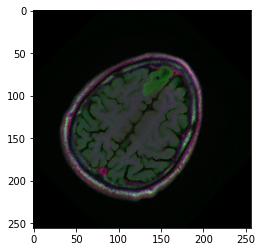

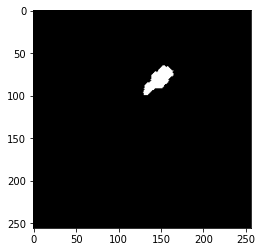

In [ ]:
image_test = cv.imread("/content/sample_data/augmented/TCGA_DU_5849_19950405_29_aug_im.tif")
mask_test = cv.imread("/content/sample_data/augmented/TCGA_DU_5849_19950405_29_aug_mask.tif")

plt.imshow(image_test)
plt.show()

plt.imshow(mask_test)
plt.show()

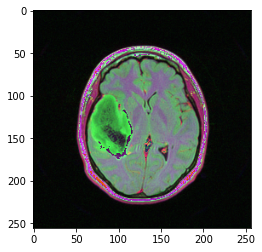

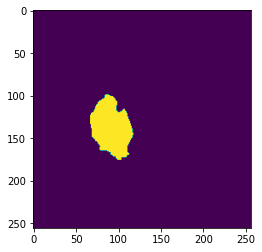

In [ ]:
def show_image_mask_from_tensor(image,mask):
    transform = transforms.ToPILImage()
    image = transform(image)
    mask = transform(mask)
    plt.imshow(image,vmin=0, vmax=1)
    plt.show()
    plt.imshow(mask)
    plt.show()
image,mask = next(iter(train_dataloader))

show_image_mask_from_tensor(image[0,:,:,:],mask[0,:,:,:])

**Importing the model and testing flowthrough of information**

**My implementation of a the U-net architecture**

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self,input_channels,output_channels):
        super(DoubleConv, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size = 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channels, output_channels, kernel_size = 3, padding=1),
            nn.BatchNorm2d(output_channels,track_running_stats=False),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        return self.model(x)

class Unet(nn.Module):
    def __init__(self,output_features):
        super(Unet, self).__init__()
        
        # Down
        self.down = nn.MaxPool2d(2)
        self.d_conv1 = DoubleConv(3,64)
        self.d_conv2 = DoubleConv(64,128)
        self.d_conv3 = DoubleConv(128,256)
        self.d_conv4 = DoubleConv(256,512)
        # # Up
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)   
        self.u_conv1 = DoubleConv(256+512,256)
        self.u_conv2 = DoubleConv(256+128,128)
        self.u_conv3 = DoubleConv(64+128,64)

        # Batch Norm 
        self.BatchNorm_conv1 = BatchNorm2d(64) # Output channels from the previous layer
        self.BatchNorm_conv2 = BatchNorm2d(128) # Output channels from the previous layer
        self.BatchNorm_conv2 = BatchNorm2d(256) # Output channels from the previous layer
        self.BatchNorm_conv2 = BatchNorm2d(512) # Output channels from the previous layer


        self.last = nn.Conv2d(64,1,kernel_size=1)

    def forward(self,x):
        # Down
        # print("Input",x.shape)
        conv_1 = self.d_conv1(x)

        x = self.down(conv_1)
        # print("Down1",x.shape)
        conv_2 = self.d_conv2(x)
        x = self.down(conv_2)
        # print("Down2",x.shape)
        conv_3 = self.d_conv3(x)
        x = self.down(conv_3)
        conv_4 = self.d_conv4(x)
       
        x = self.up(conv_4)    
        x = torch.cat([x, conv_3],axis=1)
        x = self.u_conv1(x)
        x = self.up(x)

        # print(x.shape,conv_2.shape)
        x = torch.cat([x,conv_2],axis=1)
        x = self.u_conv2(x)
        x = self.up(x)
        x = torch.cat([x,conv_1],axis=1)
        x = self.u_conv3(x)

        x = self.last(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [ ]:
net = Unet(1)
print(net)


Unet(
  (down): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (d_conv1): DoubleConv(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (4): ReLU(inplace=True)
    )
  )
  (d_conv2): DoubleConv(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (4): ReLU(inplace=True)
    )
  )
  (d_conv3): DoubleConv(
    (model): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv

In [ ]:
print(get_n_params(net))
test_image = image[0,:,:,:].unsqueeze(0)
test_mask = mask[0,:,:,:].unsqueeze(0)
output = net(test_image)
print(output.shape)

7786881
torch.Size([1, 1, 256, 256])


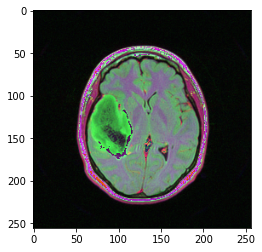

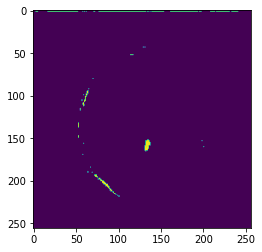

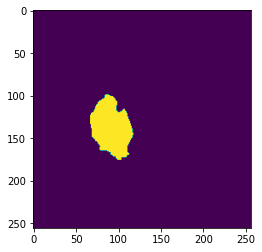

In [ ]:
def show_network_output(input_image,output_image,mask,threshold=False):
    if threshold:
      thresh = nn.Threshold(threshold,0)
      output_image = thresh(output_image)
    
    transform = transforms.ToPILImage()
    input = transform(input_image[0,:,:,:])
    output = transform(output_image[0,:,:,:])
    mask = transform(mask[0,:,:,:])

    plt.imshow(input)
    plt.show()

    plt.imshow(output)
    plt.show()

    plt.imshow(mask)
    plt.show()

show_network_output(test_image,output,mask,0.9)


In [ ]:
def validate(model,val_loader,criterion,device):
    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for i,data in enumerate(val_loader):
        image, mask = data
        image, mask = image.to(device), mask.to(device)
        output = model(image)
        loss = criterion(output,mask)
        valid_loss += loss.item()
    return valid_loss / len(val_loader)

def train(model, device, epochs, train_loader, val_loader):
    # Optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(),lr=1e-4) # 1e-5
    iterator_print = 10
    patience = 4

    train_losses_pr_epoch = []
    validation_losses_pr_epoch = []
    len_of_train_loader = len(train_dataloader)

    model.to(device)
    print("## Network transffered to device")
    for epoch in range(epochs):
        # Training the Unet Model and tracking the loss throught the mini-batches
        running_loss = 0.0
        model.train()
        for i,data in enumerate(train_loader,0):
            image, mask = data 
            image, mask = image.to(device), mask.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(image)
            loss = criterion(outputs, mask)
            del image,mask
            torch.cuda.empty_cache()
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
            if (i+1) % iterator_print == 0:    # print every iterator_print mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / iterator_print:.3f}')
                running_loss = 0.0
            


        # Calculating training loss
        model.eval()
        train_loss = 0.0
        for i,data in enumerate(train_loader,0):
            image, mask = data 
            image, mask = image.to(device), mask.to(device)
            outputs = net(image)
            loss = criterion(outputs, mask)
            train_loss += loss.item()
        
        cur_train_loss = train_loss/len(train_loader)
        cur_val_loss = validate(model, val_loader, criterion,device)

        train_losses_pr_epoch.append(cur_train_loss)
        validation_losses_pr_epoch.append(cur_val_loss)

        print(f'## Epoch: [{epoch + 1}] Training loss: {cur_train_loss:.3f} Validation loss: {cur_val_loss:.3f}')

        # Early stopping
        the_current_val_loss = validation_losses_pr_epoch[-1]
        the_last_val_loss = 0 if len(validation_losses_pr_epoch) < 2 else validation_losses_pr_epoch[-2]

        if the_current_val_loss > the_last_val_loss:
            trigger_times += 1

            if trigger_times >= patience:
                print('Early stopping at epoch',epoch," with patience",patience)
                return model, train_losses_pr_epoch, validation_losses_pr_epoch

        else:
            trigger_times = 0


    return model, train_losses_pr_epoch, validation_losses_pr_epoch


In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

11791

In [ ]:
net = Unet(1)
trained_model, train_losses_pr_epoch, validation_losses_pr_epoch = train(net,device,2,train_dataloader,val_dataloader)

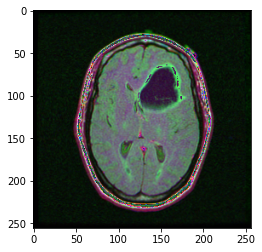

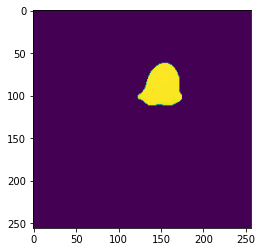

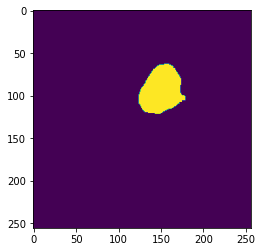

In [ ]:
trained_model.cpu()
image,mask = next(iter(val_dataloader))
test_image = image[0,:,:,:].unsqueeze(0)
test_mask = mask[0,:,:,:].unsqueeze(0)
output = trained_model(test_image)
show_network_output(test_image,output,test_mask,threshold=0.9)

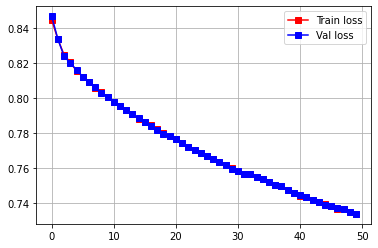

In [ ]:
def plot_training_validation_curves(train_loss,val_loss):
  N_epochs = len(train_loss)
  plt.plot(np.arange(N_epochs),train_loss,marker="s",color="r",label="Train loss")
  plt.plot(np.arange(N_epochs),val_loss,marker="s",color="b",label="Val loss")
  plt.legend()
  plt.grid(True)
  plt.show()

plot_training_validation_curves(train_losses_pr_epoch,validation_losses_pr_epoch)

In [ ]:
def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(0)
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    intersection = (m1 * m2).sum().float()

    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

def get_testing_performance(trained_model,device,test_dataloader):
    test_loss_BCE = 0.0
    test_DICE_coef = 0.0
    trained_model.to(device)
    model.eval()     # Optional when not using Model Specific layer
    for i,data in enumerate(test_dataloader):
        image, mask = data
        image, mask = image.to(device), mask.to(device)
        output = model(image)
        BCE_loss = criterion(output,mask)
        dice_coef = dice_coeff(output,mask)
        test_loss_BCE += BCE_loss.item()
        test_DICE_coef += dice_coef
    
    average_test_loss_BCE = test_loss_BCE / len(test_dataloader)
    average_test_dice_coef = test_DICE_coef / len(test_dataloader)


    return average_test_loss_BCE,average_test_dice_coef


average_test_loss_BCE,average_test_dice_coef = get_testing_performance(trained_model,device,test_dataloader)
print(f"# Average BCE loss on testing data {average_test_loss_BCE}\n# Average DICE coef on testing data {average_test_dice_coef}")
